## Imports

We import the libraries that we need for this project

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

## Data prep

We import the training data set and create lagging feature based on the consumption. Additionally, we assume that the electricity price and some weather information are available 24 hours ahead.

In [2]:
data = pd.read_csv("ellevio-load-forecast-dataset.csv")
data.timestamp = pd.to_datetime(data.timestamp)
data['Time'] = np.arange(len(data.index))
data.holiday_flag = data.holiday_flag.replace({"Y":1, "N":0})
data = pd.get_dummies(data)
data = data.dropna()
data = data[data.timestamp >= "2013-1-01 00:00:00"]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45809 entries, 8785 to 54767
Data columns (total 38 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   timestamp                                                   45809 non-null  datetime64[ns]
 1   temperature_forecast                                        45809 non-null  float64       
 2   holiday_flag                                                45809 non-null  int64         
 3   work_day                                                    45809 non-null  int64         
 4   power                                                       45809 non-null  float64       
 5   hour                                                        45809 non-null  int64         
 6   cal_week_in_year                                            45809 non-null  int64         
 7   cal_day_in_year    

## Data Viz

To get an idea of how the consumption behaves we plot the power consumption over time. We see that there is some seasonality as well a slight upwards trend.

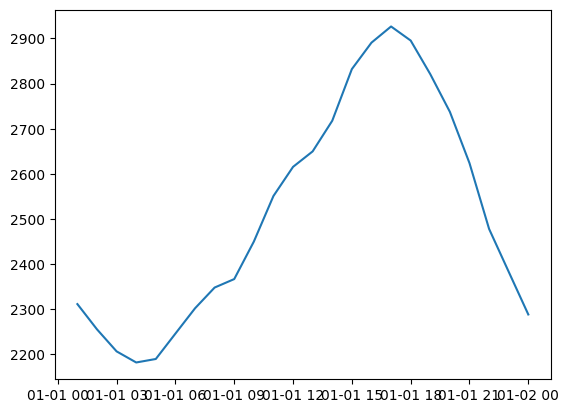

In [92]:
plt.figure()
plt.plot(data.timestamp.head(24), data.power.head(24))
plt.show()

## Data Gen

In [32]:
from TimeGAN.timegan import timegan
from TimeGAN.data_loading import real_data_loading, MinMaxScaler

## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

In [86]:
data.select_dtypes(include=["float"]).columns

Index(['temperature_forecast', 'power', 'electricity_price', 'temperature',
       'wind_direction', 'wind_speed', 'humidity', 'global_irradiance'],
      dtype='object')

In [96]:
def my_data_loading(data, seq_len, scale=True):
    if scale:
        num_d = data.select_dtypes(include=["float"])
        data[num_d.columns] = MinMaxScaler(num_d) if scale else data

    np_data = np.asarray(data.drop("timestamp", axis=1))
    temp_data = []
    # Cut data by sequence length
    for i in range(0, len(np_data) - seq_len):
        _x = np_data[i:i + seq_len]
        temp_data.append(_x)
    return temp_data

ori_data = my_data_loading(data, 72)
ori_data

[array([[0.48053959, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48053959, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48749093, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.41555985, 0.        , 1.        , ..., 0.        , 0.        ,
         1.        ],
        [0.4175999 , 0.        , 1.        , ..., 0.        , 0.        ,
         1.        ],
        [0.42159607, 0.        , 1.        , ..., 0.        , 0.        ,
         1.        ]]),
 array([[0.48053959, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48749093, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.48848998, 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.4175999 , 0.        , 1.        , ..., 0.        , 0.        ,
         1.        ],
        [0.4

In [97]:
generated_data = timegan(ori_data, parameters)

2023-10-30 12:14:40.487270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-10-30 12:14:40.487285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


Start Embedding Network Training
step: 0/10000, e_loss: 0.4373
step: 1000/10000, e_loss: 0.2289
step: 2000/10000, e_loss: 0.2289
step: 3000/10000, e_loss: 0.2292
step: 4000/10000, e_loss: 0.1614
step: 5000/10000, e_loss: 0.1383
step: 6000/10000, e_loss: 0.1035
step: 7000/10000, e_loss: 0.089
step: 8000/10000, e_loss: 0.0874
step: 9000/10000, e_loss: 0.0836
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2967
step: 1000/10000, s_loss: 0.0823
step: 2000/10000, s_loss: 0.0767
step: 3000/10000, s_loss: 0.0693
step: 4000/10000, s_loss: 0.0748
step: 5000/10000, s_loss: 0.0689
step: 6000/10000, s_loss: 0.0661
step: 7000/10000, s_loss: 0.0638
step: 8000/10000, s_loss: 0.0629
step: 9000/10000, s_loss: 0.0613
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/10000, d_loss: 1.9961, g_loss_u: 0.8772, g_loss_s: 0.0735, g_loss_v: 0.2753, e_loss_t0: 0.1371
step: 1000/10000, d_loss: 1.1512, g_loss_u: 1.2713, g_loss_s: 0.0777, g_l

In [98]:
generated_data[0][:,4]

array([10.43859115,  6.45866835,  3.1786963 ,  1.50199294, 13.95250434,
       14.43605745, 13.52218491, 11.34017214,  4.72784296,  0.0681183 ,
        0.24776331,  0.44373855,  0.04436392,  0.1059005 ,  0.22749308,
        0.44649681,  0.79574287,  1.35212678,  2.16849151,  3.25304264,
        4.58540779,  6.08743912,  7.67516857,  9.24421257, 10.74027565,
       12.10534859, 13.35215133, 14.46597612, 15.43830413, 16.24328554,
       16.95183325, 17.58423531, 18.12614655, 18.6202625 , 19.04764819,
       19.43389845, 19.76499712, 20.03523302, 20.28133821, 20.50252306,
       20.67650211, 20.85181367, 21.00664389, 21.14110792, 21.26661444,
       21.38813299, 21.49353653, 21.58281136, 21.65002829, 21.72181582,
       21.78794014, 21.86395419, 21.92958635, 21.96623617, 21.99530625,
       22.04534435, 22.09462845, 22.12805665, 22.15038323, 22.17521995,
       22.19886398, 22.22490025, 22.24662638, 22.2671324 , 22.28543264,
       22.30903828, 22.33510196, 22.34764302, 22.35763693, 22.37

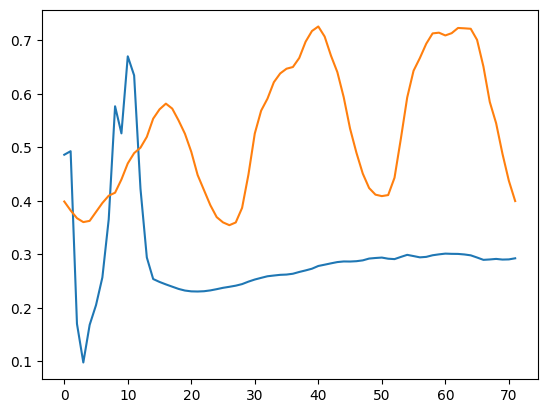

In [99]:
plt.figure()
plt.plot(generated_data[0][:,3])
plt.plot(ori_data[0][:,3])